In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR

from tqdm import tqdm
from io import StringIO
import sys

%matplotlib inline
import matplotlib.pyplot as plt


In [2]:

# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor()
                                       #transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor()
                                       #transforms.Normalize((0.1307,), (0.3081,))
                                       ])



In [3]:

# Dataset and Creating Train/Test Split

train = datasets.CIFAR100('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR100('./data', train=False, download=True, transform=test_transforms)



In [4]:
# Dataloader Arguments & Test/Train Dataloaders

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


CUDA Available? True


In [5]:
raw_train_data = train.data  

In [6]:
raw_train_data.max(), raw_train_data.min(), raw_train_data.mean()

(np.uint8(255), np.uint8(0), np.float64(121.936059453125))

torch.Size([128, 3, 32, 32])
torch.Size([128])


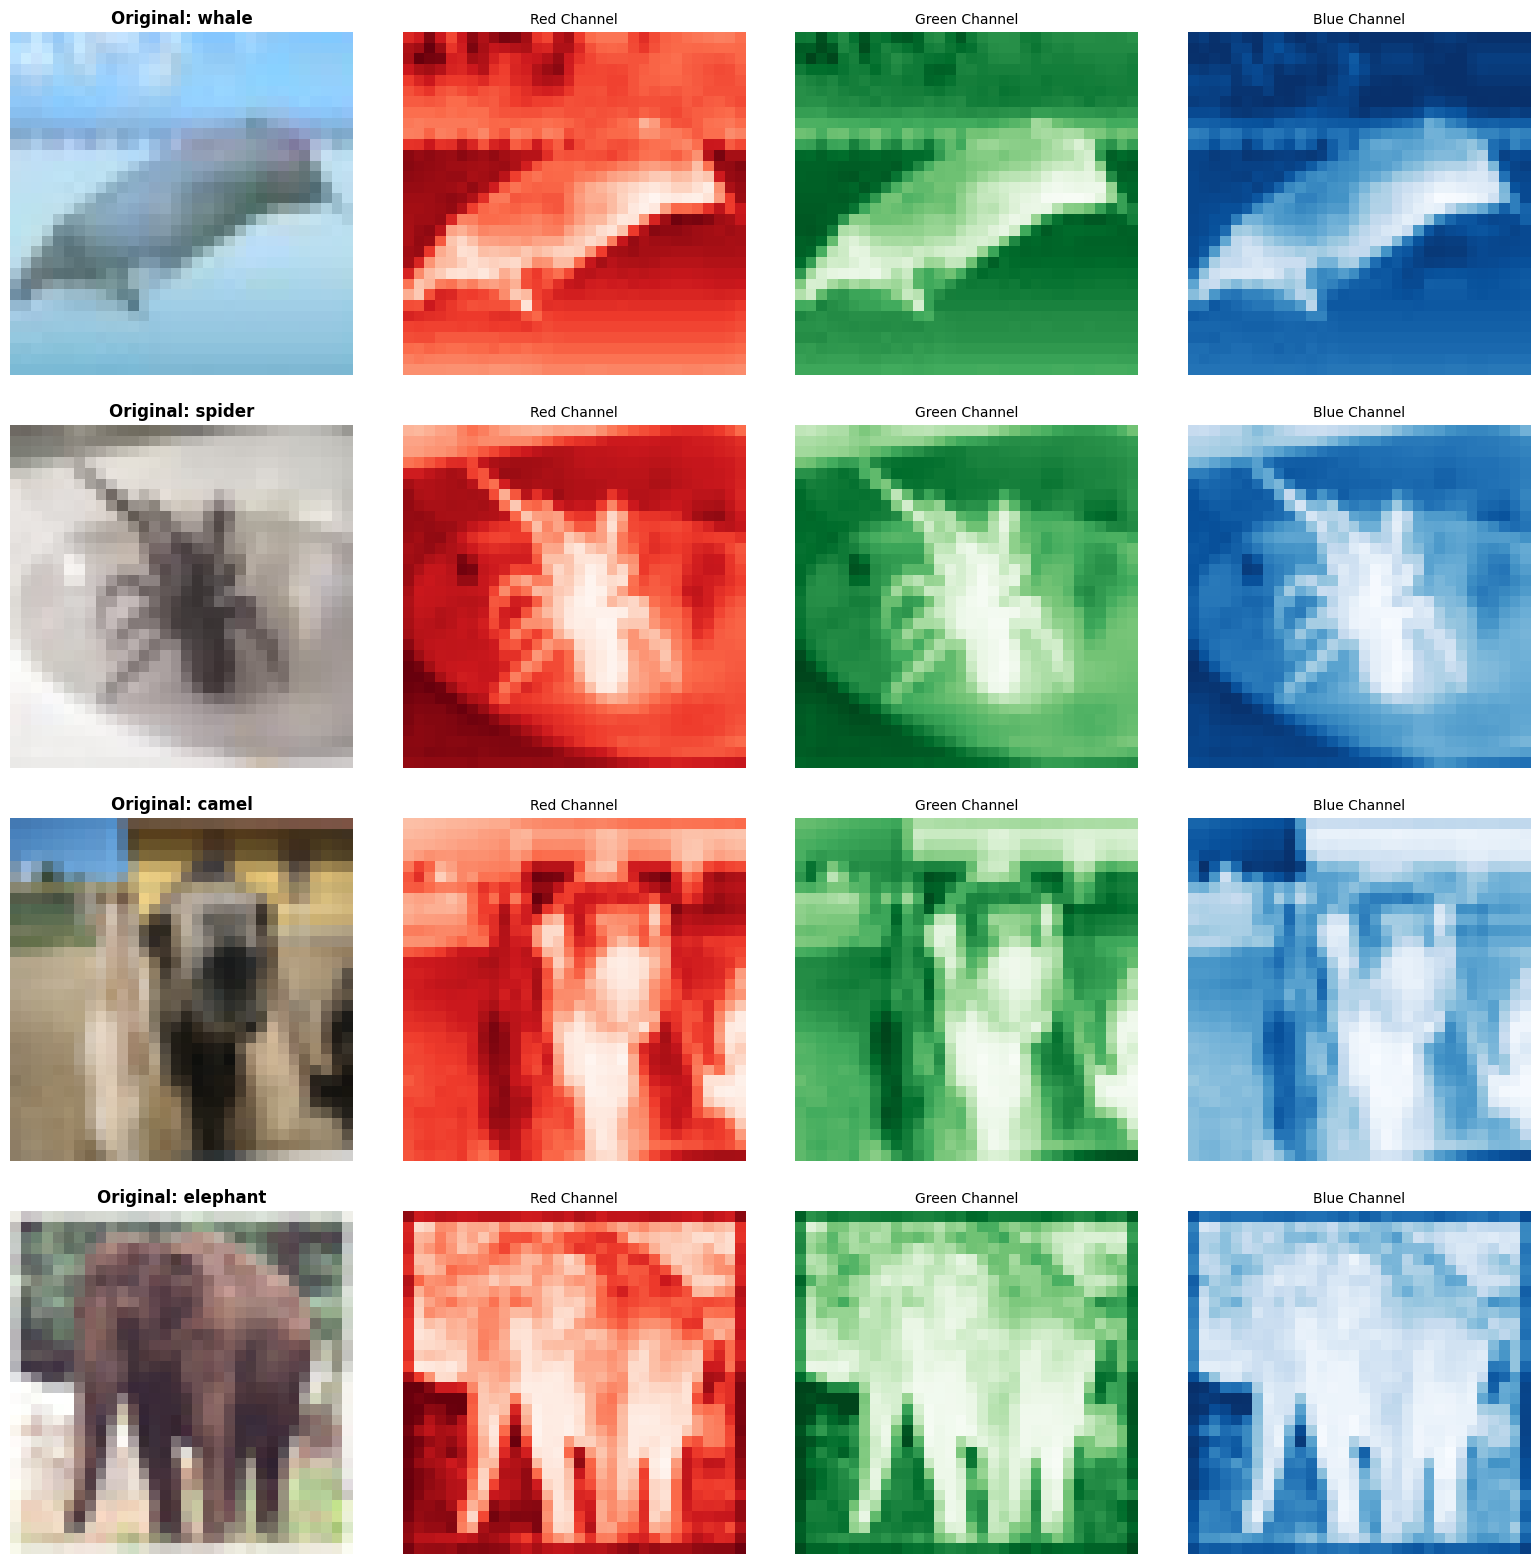

In [7]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# CIFAR-100 class names
classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 
    'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 
    'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 
    'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 
    'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 
    'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 
    'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

print(images.shape)
print(labels.shape)

# Create a 4x4 grid showing 4 samples with their RGB channels
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for i in range(4):  # Show 4 samples
    img = images[i].permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    
    # Original RGB image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'Original: {classes[labels[i]]}', fontsize=12, fontweight='bold')
    axes[i, 0].axis('off')
    
    # Red channel
    axes[i, 1].imshow(img[:,:,0], cmap='Reds')
    axes[i, 1].set_title('Red Channel', fontsize=10)
    axes[i, 1].axis('off')
    
    # Green channel
    axes[i, 2].imshow(img[:,:,1], cmap='Greens')
    axes[i, 2].set_title('Green Channel', fontsize=10)
    axes[i, 2].axis('off')
    
    # Blue channel
    axes[i, 3].imshow(img[:,:,2], cmap='Blues')
    axes[i, 3].set_title('Blue Channel', fontsize=10)
    axes[i, 3].axis('off')

plt.tight_layout(pad=2.0)
plt.show()

Images are of 32x32 resolution with 3 channels - 10 classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

60000 total frames , 50000 Train - 10000 Test set

Hence , we are dealing 500000x32x32 pixel values as input



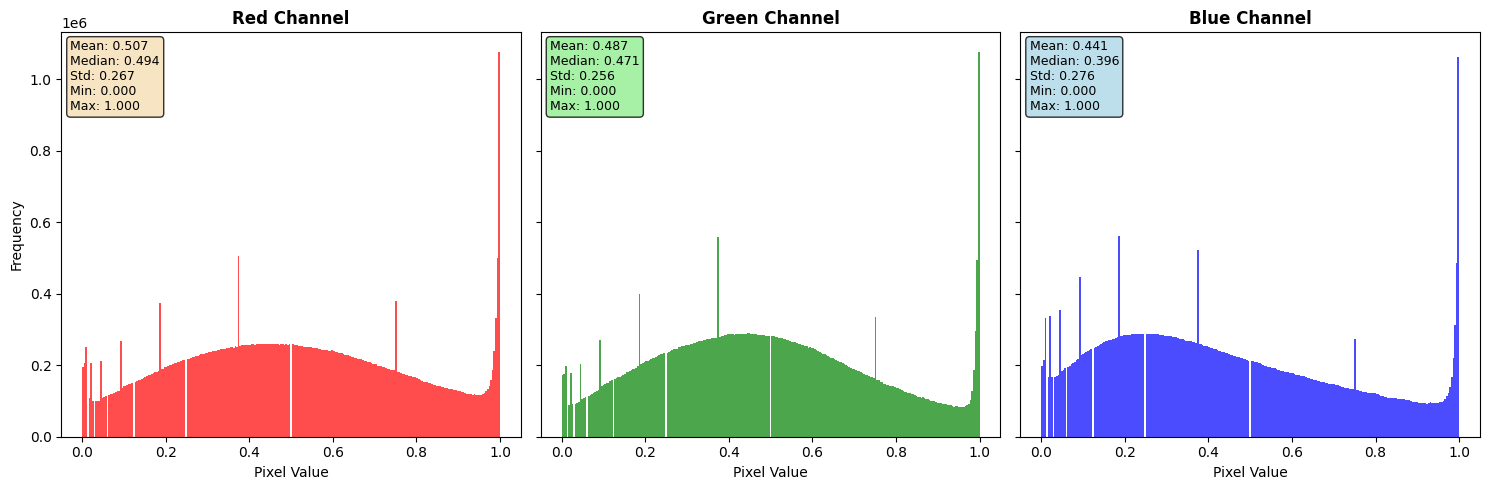

In [8]:
import numpy as np

raw_train_data = raw_train_data.astype(np.float32)  ## mimic the ToTensor() transformation

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(15, 5))

# Calculate statistics for each channel
red_data = raw_train_data[:,:,:,0].ravel()/255.0
green_data = raw_train_data[:,:,:,1].ravel()/255.0
blue_data = raw_train_data[:,:,:,2].ravel()/255.0

# Red channel
axs[0].hist(red_data, bins=255, color='red', alpha=0.7)
red_stats = f'Mean: {np.mean(red_data):.3f}\nMedian: {np.median(red_data):.3f}\nStd: {np.std(red_data):.3f}\nMin: {np.min(red_data):.3f}\nMax: {np.max(red_data):.3f}'
axs[0].set_title('Red Channel', fontsize=12, fontweight='bold')
axs[0].text(0.02, 0.98, red_stats, transform=axs[0].transAxes, fontsize=9, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
axs[0].set_xlabel('Pixel Value')
axs[0].set_ylabel('Frequency')

# Green channel
axs[1].hist(green_data, bins=255, color='green', alpha=0.7)
green_stats = f'Mean: {np.mean(green_data):.3f}\nMedian: {np.median(green_data):.3f}\nStd: {np.std(green_data):.3f}\nMin: {np.min(green_data):.3f}\nMax: {np.max(green_data):.3f}'
axs[1].set_title('Green Channel', fontsize=12, fontweight='bold')
axs[1].text(0.02, 0.98, green_stats, transform=axs[1].transAxes, fontsize=9, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
axs[1].set_xlabel('Pixel Value')

# Blue channel
axs[2].hist(blue_data, bins=255, color='blue', alpha=0.7)
blue_stats = f'Mean: {np.mean(blue_data):.3f}\nMedian: {np.median(blue_data):.3f}\nStd: {np.std(blue_data):.3f}\nMin: {np.min(blue_data):.3f}\nMax: {np.max(blue_data):.3f}'
axs[2].set_title('Blue Channel', fontsize=12, fontweight='bold')
axs[2].text(0.02, 0.98, blue_stats, transform=axs[2].transAxes, fontsize=9, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
axs[2].set_xlabel('Pixel Value')

plt.tight_layout()
plt.show()

Since there is differences in distribution between RGB channels , It is adviced to apply channel wise image norm

In [9]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# Convert to PyTorch tensor first, then scale
raw_train_data = train.data  
float_data = torch.tensor(raw_train_data, dtype=torch.float32) / 255.0

print('[Train - Overall]')
print(' - Numpy Shape:', raw_train_data.shape)
print(' - Tensor Shape:', float_data.size())
print(' - min:', torch.min(float_data))
print(' - max:', torch.max(float_data))
print(' - mean:', torch.mean(float_data))
print(' - std:', torch.std(float_data))
print(' - var:', torch.var(float_data))

print('\n[Train - Channel-wise Statistics]')
print('=' * 50)

# Channel-wise statistics
for i, channel in enumerate(['Red', 'Green', 'Blue']):
    channel_data = float_data[:, :, :, i]
    print(f'\n{channel} Channel (Channel {i}):')
    print(f' - Shape: {channel_data.shape}')
    print(f' - Min: {torch.min(channel_data):.6f}')
    print(f' - Max: {torch.max(channel_data):.6f}')
    print(f' - Mean: {torch.mean(channel_data):.6f}')
    print(f' - Median: {torch.median(channel_data):.6f}')
    print(f' - Std: {torch.std(channel_data):.6f}')
    print(f' - Var: {torch.var(channel_data):.6f}')
    print(f' - Range: {torch.max(channel_data) - torch.min(channel_data):.6f}')
    
    # Memory-efficient percentile calculation using numpy
    channel_np = channel_data.numpy()
    print(f' - 25th Percentile: {np.percentile(channel_np, 25):.6f}')
    print(f' - 75th Percentile: {np.percentile(channel_np, 75):.6f}')

# Summary table
print('\n[Summary Table]')
print('=' * 80)
print(f"{'Channel':<8} {'Min':<8} {'Max':<8} {'Mean':<8} {'Median':<8} {'Std':<8} {'Var':<8}")
print('-' * 80)

for i, channel in enumerate(['Red', 'Green', 'Blue']):
    channel_data = float_data[:, :, :, i]
    print(f"{channel:<8} {torch.min(channel_data):.4f} {torch.max(channel_data):.4f} "
          f"{torch.mean(channel_data):.4f} {torch.median(channel_data):.4f} "
          f"{torch.std(channel_data):.4f} {torch.var(channel_data):.4f}")

# Additional insights
print('\n[Additional Insights]')
print('=' * 50)

# Check if data is normalized
red_mean = torch.mean(float_data[:, :, :, 0])
green_mean = torch.mean(float_data[:, :, :, 1])
blue_mean = torch.mean(float_data[:, :, :, 2])

print(f'Red channel mean: {red_mean:.4f}')
print(f'Green channel mean: {green_mean:.4f}')
print(f'Blue channel mean: {blue_mean:.4f}')

# Check for any potential issues
print(f'\nData range check:')
print(f' - All values >= 0: {torch.all(float_data >= 0)}')
print(f' - All values <= 1: {torch.all(float_data <= 1)}')
print(f' - Any NaN values: {torch.any(torch.isnan(float_data))}')
print(f' - Any Inf values: {torch.any(torch.isinf(float_data))}')

# Channel correlation (using a sample for memory efficiency)
print(f'\nChannel correlations (using 10% sample):')
sample_size = len(float_data) // 10  # Use 10% of data
sample_indices = torch.randperm(len(float_data))[:sample_size]
sample_data = float_data[sample_indices]

red_flat = sample_data[:, :, :, 0].flatten()
green_flat = sample_data[:, :, :, 1].flatten()
blue_flat = sample_data[:, :, :, 2].flatten()

print(f' - Red-Green correlation: {torch.corrcoef(torch.stack([red_flat, green_flat]))[0, 1]:.4f}')
print(f' - Red-Blue correlation: {torch.corrcoef(torch.stack([red_flat, blue_flat]))[0, 1]:.4f}')
print(f' - Green-Blue correlation: {torch.corrcoef(torch.stack([green_flat, blue_flat]))[0, 1]:.4f}')

[Train - Overall]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([50000, 32, 32, 3])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.4782)
 - std: tensor(0.2682)
 - var: tensor(0.0719)

[Train - Channel-wise Statistics]

Red Channel (Channel 0):
 - Shape: torch.Size([50000, 32, 32])
 - Min: 0.000000
 - Max: 1.000000
 - Mean: 0.507076
 - Median: 0.494118
 - Std: 0.267334
 - Var: 0.071468
 - Range: 1.000000
 - 25th Percentile: 0.298039
 - 75th Percentile: 0.709804

Green Channel (Channel 1):
 - Shape: torch.Size([50000, 32, 32])
 - Min: 0.000000
 - Max: 1.000000
 - Mean: 0.486550
 - Median: 0.470588
 - Std: 0.256438
 - Var: 0.065761
 - Range: 1.000000
 - 25th Percentile: 0.290196
 - 75th Percentile: 0.666667

Blue Channel (Channel 2):
 - Shape: torch.Size([50000, 32, 32])
 - Min: 0.000000
 - Max: 1.000000
 - Mean: 0.440919
 - Median: 0.396078
 - Std: 0.276150
 - Var: 0.076259
 - Range: 1.000000
 - 25th Percentile: 0.215686
 - 75th Percentile: 0.639216

[Summary Ta

In [24]:
import Data_Manager

In [26]:
Data_Manager.CIFAR100DataManager()

AttributeError: module 'Data_Manager' has no attribute 'CIFAR100DataManager'

In [12]:
# Cell 1: Import and setup
import sys
import os
sys.path.append('.')

from Data_Manager import DataConfig, CIFAR100DataManager, Logger, Config
import torch
import numpy as np
import matplotlib.pyplot as plt

# Create configuration
config = Config()
config.data.batch_size = 128
config.data.data_dir = './data'

# Create logger
logger = Logger(config.logging)

print("Configuration loaded successfully!")
print(f"Data directory: {config.data.data_dir}")
print(f"Batch size: {config.data.batch_size}")
print(f"CIFAR-10 mean: {config.data.cifar100_mean}")
print(f"CIFAR-10 std: {config.data.cifar100_std}")

Configuration loaded successfully!
Data directory: ./data
Batch size: 128
CIFAR-10 mean: (0.507076, 0.48655, 0.440919)
CIFAR-10 std: (0.267334, 0.256438, 0.27615)


In [13]:
# Cell 2: Create DataManager and load data
# Create data manager
data_manager = CIFAR100DataManager(config.data, logger)

# Load datasets (this returns datasets, not dataloaders based on your current code)
train_dataset, test_dataset = data_manager.load_data()

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Classes: {data_manager.classes}")

2025-10-04 16:13:07,482 - CIFAR-100_Training - INFO - Loading CIFAR-100 dataset...
2025-10-04 16:13:10,033 - CIFAR-100_Training - INFO - CIFAR-100 dataset loaded successfully!
2025-10-04 16:13:10,034 - CIFAR-100_Training - INFO - Train samples: 50000
2025-10-04 16:13:10,035 - CIFAR-100_Training - INFO - Test samples: 10000


Train dataset size: 391
Test dataset size: 79
Classes: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',

In [14]:
# Cell 3: Get dataset-level normalized statistics
def get_dataset_normalized_stats(data_manager, batch_size=1000, num_batches=None):
    """
    Get comprehensive statistics from the entire dataset after normalization.
    Uses the DataManager's dataset with transforms applied.
    """
    from torch.utils.data import DataLoader
    
    # Create dataloader from the dataset (which has transforms applied)
    dataloader = DataLoader(
        data_manager.train_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0
    )
    
    # Initialize accumulators
    all_images = []
    red_channel = []
    green_channel = []
    blue_channel = []
    
    print("Processing dataset for normalized statistics...")
    
    # Process batches
    for i, (images, labels) in enumerate(dataloader):
        if num_batches is not None and i >= num_batches:
            break
            
        if i % 10 == 0:
            print(f"Processed {i} batches...")
        
        # Collect all images (these are already normalized!)
        all_images.append(images)
        
        # Collect channel-wise data
        red_channel.append(images[:, 0, :, :].flatten())
        green_channel.append(images[:, 1, :, :].flatten())
        blue_channel.append(images[:, 2, :, :].flatten())
    
    # Concatenate all data
    all_images = torch.cat(all_images, dim=0)
    red_channel = torch.cat(red_channel, dim=0)
    green_channel = torch.cat(green_channel, dim=0)
    blue_channel = torch.cat(blue_channel, dim=0)
    
    print(f"Total images processed: {len(all_images)}")
    print(f"Image shape: {all_images.shape}")
    
    # Overall statistics
    overall_stats = {
        'shape': all_images.shape,
        'min': torch.min(all_images).item(),
        'max': torch.max(all_images).item(),
        'mean': torch.mean(all_images).item(),
        'std': torch.std(all_images).item(),
        'var': torch.var(all_images).item()
    }
    
    # Channel-wise statistics
    channel_stats = {}
    for i, (channel_name, channel_data) in enumerate([('Red', red_channel), ('Green', green_channel), ('Blue', blue_channel)]):
        channel_stats[channel_name.lower()] = {
            'min': torch.min(channel_data).item(),
            'max': torch.max(channel_data).item(),
            'mean': torch.mean(channel_data).item(),
            'median': torch.median(channel_data).item(),
            'std': torch.std(channel_data).item(),
            'var': torch.var(channel_data).item(),
            'range': (torch.max(channel_data) - torch.min(channel_data)).item()
        }
    
    return {
        'overall': overall_stats,
        'channels': channel_stats,
        'all_images': all_images,
        'red_channel': red_channel,
        'green_channel': green_channel,
        'blue_channel': blue_channel
    }

# Get normalized statistics for training dataset
print("Getting normalized statistics for training dataset...")
train_stats = get_dataset_normalized_stats(data_manager, batch_size=1000, num_batches=50)  # Process 50 batches (50k images)

print("\n" + "="*60)
print("NORMALIZED DATASET STATISTICS (Training Set)")
print("="*60)

# Overall statistics
print(f"Overall Statistics:")
print(f"  - Shape: {train_stats['overall']['shape']}")
print(f"  - Min: {train_stats['overall']['min']:.6f}")
print(f"  - Max: {train_stats['overall']['max']:.6f}")
print(f"  - Mean: {train_stats['overall']['mean']:.6f}")
print(f"  - Std: {train_stats['overall']['std']:.6f}")
print(f"  - Var: {train_stats['overall']['var']:.6f}")

print(f"\nChannel-wise Statistics:")
for channel, stats in train_stats['channels'].items():
    print(f"\n{channel.capitalize()} Channel:")
    print(f"  - Min: {stats['min']:.6f}")
    print(f"  - Max: {stats['max']:.6f}")
    print(f"  - Mean: {stats['mean']:.6f}")
    print(f"  - Median: {stats['median']:.6f}")
    print(f"  - Std: {stats['std']:.6f}")
    print(f"  - Var: {stats['var']:.6f}")
    print(f"  - Range: {stats['range']:.6f}")

Getting normalized statistics for training dataset...
Processing dataset for normalized statistics...
Processed 0 batches...
Processed 10 batches...
Processed 20 batches...
Processed 30 batches...
Processed 40 batches...
Total images processed: 50000
Image shape: torch.Size([50000, 3, 32, 32])

NORMALIZED DATASET STATISTICS (Training Set)
Overall Statistics:
  - Shape: torch.Size([50000, 3, 32, 32])
  - Min: -1.897340
  - Max: 2.024555
  - Mean: -0.000004
  - Std: 1.000002
  - Var: 1.000003

Channel-wise Statistics:

Red Channel:
  - Min: -1.896788
  - Max: 1.843851
  - Mean: -0.000003
  - Median: -0.048473
  - Std: 1.000001
  - Var: 1.000002
  - Range: 3.740639

Green Channel:
  - Min: -1.897340
  - Max: 2.002239
  - Mean: -0.000004
  - Median: -0.062244
  - Std: 1.000002
  - Var: 1.000004
  - Range: 3.899578

Blue Channel:
  - Min: -1.596665
  - Max: 2.024555
  - Mean: -0.000004
  - Median: -0.162378
  - Std: 1.000002
  - Var: 1.000004
  - Range: 3.621221


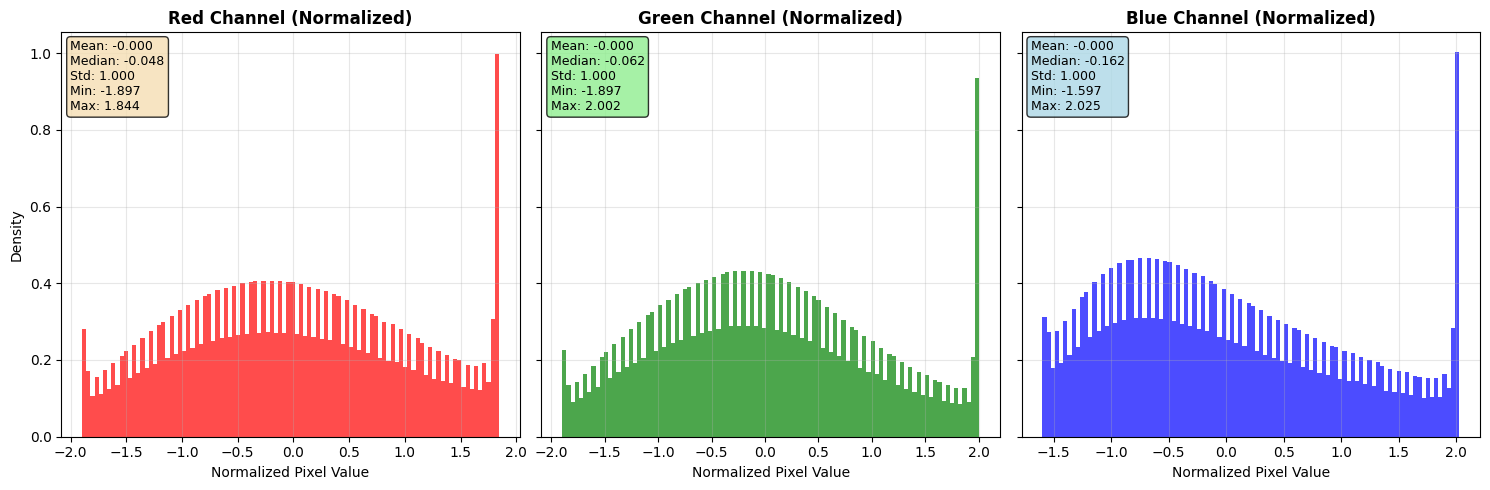

In [15]:
# Cell 4: Plot normalized channel histograms
def plot_normalized_histograms(stats, save_path=None):
    """Plot histograms for normalized data."""
    fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(15, 5))
    
    # Get channel data
    red_data = stats['red_channel']
    green_data = stats['green_channel']
    blue_data = stats['blue_channel']
    
    # Red channel
    axs[0].hist(red_data.numpy(), bins=100, color='red', alpha=0.7, density=True)
    red_stats_text = f'Mean: {torch.mean(red_data):.3f}\nMedian: {torch.median(red_data):.3f}\nStd: {torch.std(red_data):.3f}\nMin: {torch.min(red_data):.3f}\nMax: {torch.max(red_data):.3f}'
    axs[0].set_title('Red Channel (Normalized)', fontsize=12, fontweight='bold')
    axs[0].text(0.02, 0.98, red_stats_text, transform=axs[0].transAxes, fontsize=9, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    axs[0].set_xlabel('Normalized Pixel Value')
    axs[0].set_ylabel('Density')
    axs[0].grid(True, alpha=0.3)
    
    # Green channel
    axs[1].hist(green_data.numpy(), bins=100, color='green', alpha=0.7, density=True)
    green_stats_text = f'Mean: {torch.mean(green_data):.3f}\nMedian: {torch.median(green_data):.3f}\nStd: {torch.std(green_data):.3f}\nMin: {torch.min(green_data):.3f}\nMax: {torch.max(green_data):.3f}'
    axs[1].set_title('Green Channel (Normalized)', fontsize=12, fontweight='bold')
    axs[1].text(0.02, 0.98, green_stats_text, transform=axs[1].transAxes, fontsize=9, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    axs[1].set_xlabel('Normalized Pixel Value')
    axs[1].grid(True, alpha=0.3)
    
    # Blue channel
    axs[2].hist(blue_data.numpy(), bins=100, color='blue', alpha=0.7, density=True)
    blue_stats_text = f'Mean: {torch.mean(blue_data):.3f}\nMedian: {torch.median(blue_data):.3f}\nStd: {torch.std(blue_data):.3f}\nMin: {torch.min(blue_data):.3f}\nMax: {torch.max(blue_data):.3f}'
    axs[2].set_title('Blue Channel (Normalized)', fontsize=12, fontweight='bold')
    axs[2].text(0.02, 0.98, blue_stats_text, transform=axs[2].transAxes, fontsize=9, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    axs[2].set_xlabel('Normalized Pixel Value')
    axs[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Normalized histograms saved to: {save_path}")
    
    plt.show()

# Plot the normalized histograms
plot_normalized_histograms(train_stats)

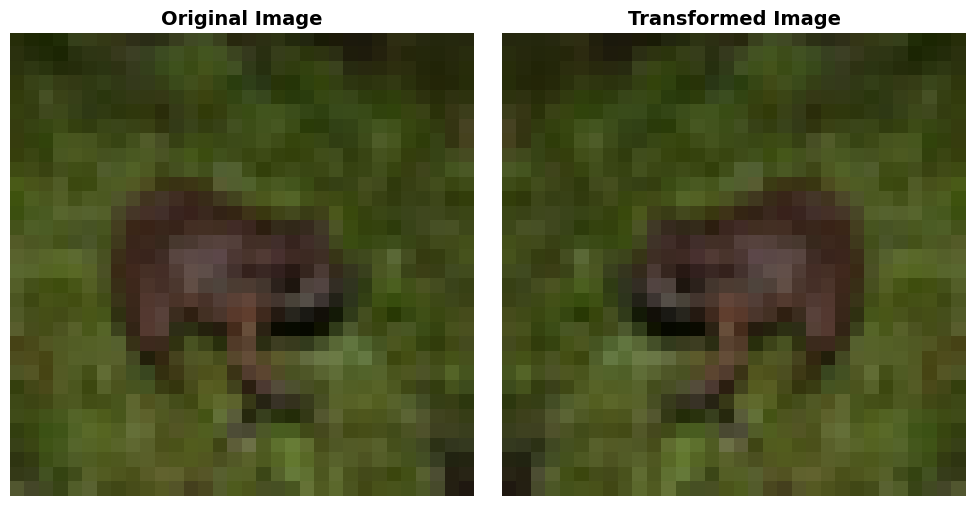

In [48]:
import torch
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from random import randint
import albumentations as albu

def visualize_transformed_images (image , flipped_image):

    # Visualize both images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Flipped image
    axes[1].imshow(flipped_image)
    axes[1].set_title('Transformed Image', fontsize=14, fontweight='bold')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

random_Image_index = randint(0,50000)

# Get the original image (numpy array)
image = data_manager.train_dataset.data[random_Image_index]

# # Convert to PIL Image (PyTorch transforms work with PIL Images)
# pil_image = Image.fromarray(image)

# # Horizontally flip using PyTorch functional API
# flipped_pil = TF.hflip(pil_image)

transform =albu.HorizontalFlip(p=0.5)
augmented_image = transform(image=image)['image']

# Convert back to numpy for visualization
flipped_image = np.array(augmented_image)

visualize_transformed_images(image ,flipped_image)


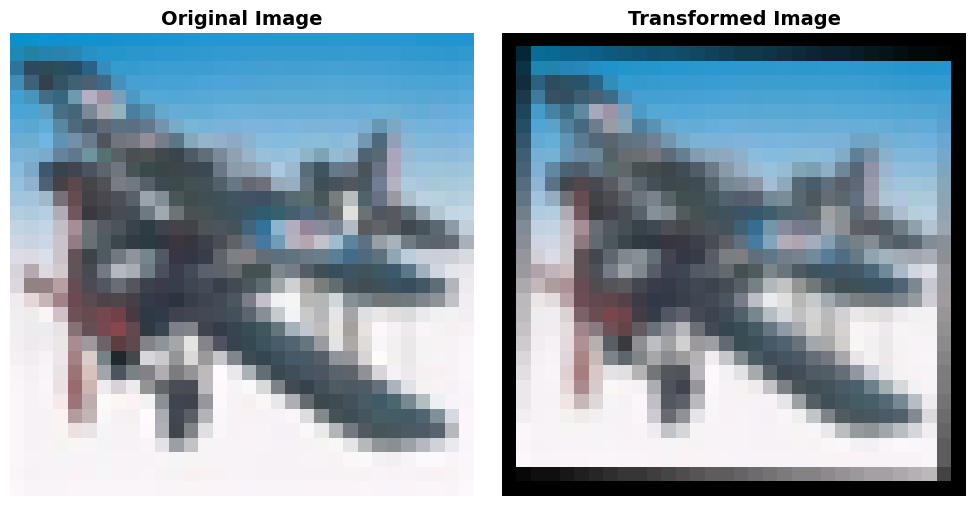

In [50]:
random_Image_index = randint(0,50000)

# Get the original image (numpy array)
image = data_manager.train_dataset.data[random_Image_index]

transform = albu.augmentations.geometric.transforms.ShiftScaleRotate(shift_limit = 0.01, scale_limit = 0.1, rotate_limit = 15)
augmented_image = transform(image=image)['image']
# Convert back to numpy for visualization
flipped_image = np.array(augmented_image)

visualize_transformed_images(image ,flipped_image)

In [16]:
random_Image_index = randint(0,50000)

# Get the original image (numpy array)
image = data_manager.train_dataset.data[random_Image_index]
transform = albu.CoarseDropout(max_holes = 1, # Maximum number of regions to zero out. (default: 8)
                    max_height = 16, # Maximum height of the hole. (default: 8) 
                    max_width = 16, # Maximum width of the hole. (default: 8) 
                    min_holes=1, # Maximum number of regions to zero out. (default: None, which equals max_holes)
                    min_height=16, # Maximum height of the hole. (default: None, which equals max_height)
                    min_width=16, # Maximum width of the hole. (default: None, which equals max_width)
                    fill_value=(125, 123, 114), # value for dropped pixels.
                    mask_fill_value=None, # fill value for dropped pixels in mask. 
                    always_apply=False
                   )
augmented_image = transform(image=image)['image']
# Convert back to numpy for visualization
flipped_image = np.array(augmented_image)

visualize_transformed_images(image ,flipped_image)


NameError: name 'randint' is not defined

Finding LR

In [40]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Import your model and config
sys.path.append('.')
from Model_Evolution.FineTune.model import ModelConfig, ModelBuilder, CIFAR100Model

%matplotlib inline

In [41]:
# Configuration for LR Finder
class SimpleConfig:
    def __init__(self):
        self.data_dir = './data'
        self.batch_size = 128
        self.num_workers = 0  # Set to 0 for notebook
        self.pin_memory = True
        
        # CIFAR-100 normalization
        self.cifar100_mean = (0.5071, 0.4867, 0.4408)
        self.cifar100_std = (0.2675, 0.2565, 0.2761)
        
        # Model config
        self.dropout_rate = 0.05
        self.num_classes = 100

config = SimpleConfig()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [42]:
# Simple transforms for LR finding (no augmentation needed)
transform = A.Compose([
    A.Normalize(mean=config.cifar100_mean, std=config.cifar100_std, max_pixel_value=255.0),
    ToTensorV2()
])

class AlbumentationsWrapper:
    def __init__(self, transform):
        self.transform = transform
    
    def __call__(self, image):
        if not isinstance(image, np.ndarray):
            image = np.array(image)
        return self.transform(image=image)['image']

# Load CIFAR-100 dataset
train_dataset = datasets.CIFAR100(
    root=config.data_dir,
    train=True,
    download=True,
    transform=AlbumentationsWrapper(transform)
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=config.pin_memory
)

print(f"Dataset loaded: {len(train_dataset)} training samples")

Dataset loaded: 50000 training samples


In [43]:
# Simple transforms for LR finding (no augmentation needed)
transform = A.Compose([
    A.Normalize(mean=config.cifar100_mean, std=config.cifar100_std, max_pixel_value=255.0),
    ToTensorV2()
])

class AlbumentationsWrapper:
    def __init__(self, transform):
        self.transform = transform
    
    def __call__(self, image):
        if not isinstance(image, np.ndarray):
            image = np.array(image)
        return self.transform(image=image)['image']

# Load CIFAR-100 dataset
train_dataset = datasets.CIFAR100(
    root=config.data_dir,
    train=True,
    download=True,
    transform=AlbumentationsWrapper(transform)
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=config.pin_memory
)

print(f"Dataset loaded: {len(train_dataset)} training samples")

Dataset loaded: 50000 training samples


In [44]:
class LRFinder:
    """Learning Rate Finder for finding optimal learning rate."""
    
    def __init__(self, model, optimizer, criterion, device):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        
        # Save initial state
        self.model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        self.optimizer_state = optimizer.state_dict()
    
    def range_test(self, train_loader, start_lr=1e-7, end_lr=10, num_iter=100, 
                   smooth_f=0.05, diverge_th=5):
        """
        Perform LR range test.
        
        Args:
            train_loader: Training data loader
            start_lr: Starting learning rate (default: 1e-7)
            end_lr: Ending learning rate (default: 10)
            num_iter: Number of iterations (default: 100)
            smooth_f: Smoothing factor for loss (default: 0.05)
            diverge_th: Divergence threshold (default: 5)
        """
        # Reset model to initial state
        self.model.load_state_dict({k: v.to(self.device) for k, v in self.model_state.items()})
        self.optimizer.load_state_dict(self.optimizer_state)
        
        # Initialize
        self.model.train()
        lrs = []
        losses = []
        best_loss = float('inf')
        avg_loss = 0.0
        
        # Calculate LR multiplier for exponential increase
        lr_multiplier = (end_lr / start_lr) ** (1 / num_iter)
        
        # Set initial LR
        lr = start_lr
        self.optimizer.param_groups[0]['lr'] = lr
        
        # Create iterator
        iterator = iter(train_loader)
        
        # Progress bar
        pbar = tqdm(range(num_iter), desc='LR Finder', ncols=100)
        
        for iteration in pbar:
            try:
                inputs, labels = next(iterator)
            except StopIteration:
                iterator = iter(train_loader)
                inputs, labels = next(iterator)
            
            # Move to device
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            
            # Compute smoothed loss
            if iteration == 0:
                avg_loss = loss.item()
            else:
                avg_loss = smooth_f * avg_loss + (1 - smooth_f) * loss.item()
            smoothed_loss = avg_loss / (1 - smooth_f ** (iteration + 1))
            
            # Update best loss
            if smoothed_loss < best_loss:
                best_loss = smoothed_loss
            
            # Store values
            lrs.append(lr)
            losses.append(smoothed_loss)
            
            # Update progress bar
            pbar.set_postfix({'LR': f'{lr:.2e}', 'Loss': f'{smoothed_loss:.4f}'})
            
            # Check for divergence
            if smoothed_loss > diverge_th * best_loss:
                print(f"\nStopping early: loss diverged at iteration {iteration}")
                break
            
            # Backward pass
            loss.backward()
            self.optimizer.step()
            
            # Update LR
            lr *= lr_multiplier
            self.optimizer.param_groups[0]['lr'] = lr
        
        return lrs, losses
    
    def plot(self, lrs, losses, skip_start=10, skip_end=5, log_lr=True, figsize=(14, 6)):
        """Plot LR finder results with recommendations."""
        
        # Trim data
        if skip_end > 0:
            lrs = lrs[skip_start:-skip_end]
            losses = losses[skip_start:-skip_end]
        else:
            lrs = lrs[skip_start:]
            losses = losses[skip_start:]
        
        # Calculate gradient to find steepest descent
        gradients = np.gradient(losses, lrs)
        min_gradient_idx = np.argmin(gradients)
        suggested_lr = lrs[min_gradient_idx]
        
        # Find minimum loss LR
        min_loss_idx = np.argmin(losses)
        min_loss_lr = lrs[min_loss_idx]
        
        # Create plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Plot 1: Loss vs LR
        ax1.plot(lrs, losses, linewidth=2, color='blue', label='Loss')
        ax1.axvline(x=suggested_lr, color='red', linestyle='--', linewidth=2, 
                   label=f'Suggested LR: {suggested_lr:.2e}')
        ax1.axvline(x=min_loss_lr, color='green', linestyle='--', linewidth=2, 
                   label=f'Min Loss LR: {min_loss_lr:.2e}')
        
        if log_lr:
            ax1.set_xscale('log')
        
        ax1.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
        ax1.set_title('Learning Rate Finder: Loss vs LR', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.legend(fontsize=10)
        
        # Plot 2: Gradient (rate of change)
        ax2.plot(lrs, gradients, linewidth=2, color='orange', label='Loss Gradient')
        ax2.axvline(x=suggested_lr, color='red', linestyle='--', linewidth=2, 
                   label=f'Steepest: {suggested_lr:.2e}')
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
        
        if log_lr:
            ax2.set_xscale('log')
        
        ax2.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Loss Gradient (dLoss/dLR)', fontsize=12, fontweight='bold')
        ax2.set_title('Loss Gradient: Find Steepest Descent', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.legend(fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        # Print recommendations
        print("\n" + "="*70)
        print("📊 LEARNING RATE FINDER RESULTS")
        print("="*70)
        print(f"\n✅ RECOMMENDED LEARNING RATE (Steepest Descent):")
        print(f"   → Primary recommendation: {suggested_lr:.2e}")
        print(f"   → Conservative (1/10):    {suggested_lr/10:.2e}")
        print(f"   → Aggressive (1/3):       {suggested_lr/3:.2e}")
        
        print(f"\n📈 MINIMUM LOSS LEARNING RATE:")
        print(f"   → LR at minimum loss: {min_loss_lr:.2e}")
        print(f"   → Use as upper bound")
        
        print(f"\n💡 RECOMMENDATIONS:")
        print(f"   1. Start with: {suggested_lr:.2e}")
        print(f"   2. If unstable, try: {suggested_lr/10:.2e}")
        print(f"   3. Max LR should be < {min_loss_lr:.2e}")
        
        print("\n" + "="*70 + "\n")
        
        return suggested_lr, min_loss_lr
    
    def find(self, train_loader, start_lr=1e-7, end_lr=10, num_iter=100):
        """
        Convenience method to run LR finder and display results.
        
        Returns:
            suggested_lr: Recommended learning rate
            min_loss_lr: LR at minimum loss
        """
        print("🔍 Starting Learning Rate Finder...")
        print(f"   Range: {start_lr:.2e} → {end_lr:.2e}")
        print(f"   Iterations: {num_iter}\n")
        
        lrs, losses = self.range_test(train_loader, start_lr, end_lr, num_iter)
        suggested_lr, min_loss_lr = self.plot(lrs, losses)
        
        return suggested_lr, min_loss_lr

In [45]:
# Create model
model_config = ModelConfig(
    input_channels=3,
    input_size=(32, 32),
    num_classes=100,
    dropout_rate=config.dropout_rate
)

builder = ModelBuilder()
model = builder.build_cifar100_model(model_config)
model = model.to(device)

print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")

Model created with 23,182,440 parameters


In [ ]:


# Create optimizer (initial LR doesn't matter, will be overridden)
optimizer = optim.SGD(
    model.parameters(),
    lr=0.01,  # Initial LR (will be overridden by LR finder)
    momentum=0.9,
    weight_decay=0.0001
)

print("Optimizer created")

Model created with 23,182,440 parameters
Optimizer created


🔍 Starting Learning Rate Finder...
   Range: 1.00e-07 → 1.00e+01
   Iterations: 200



LR Finder:  78%|██████████████████     | 157/200 [23:11<06:21,  8.86s/it, LR=1.91e-01, Loss=28.8710]



Stopping early: loss diverged at iteration 157


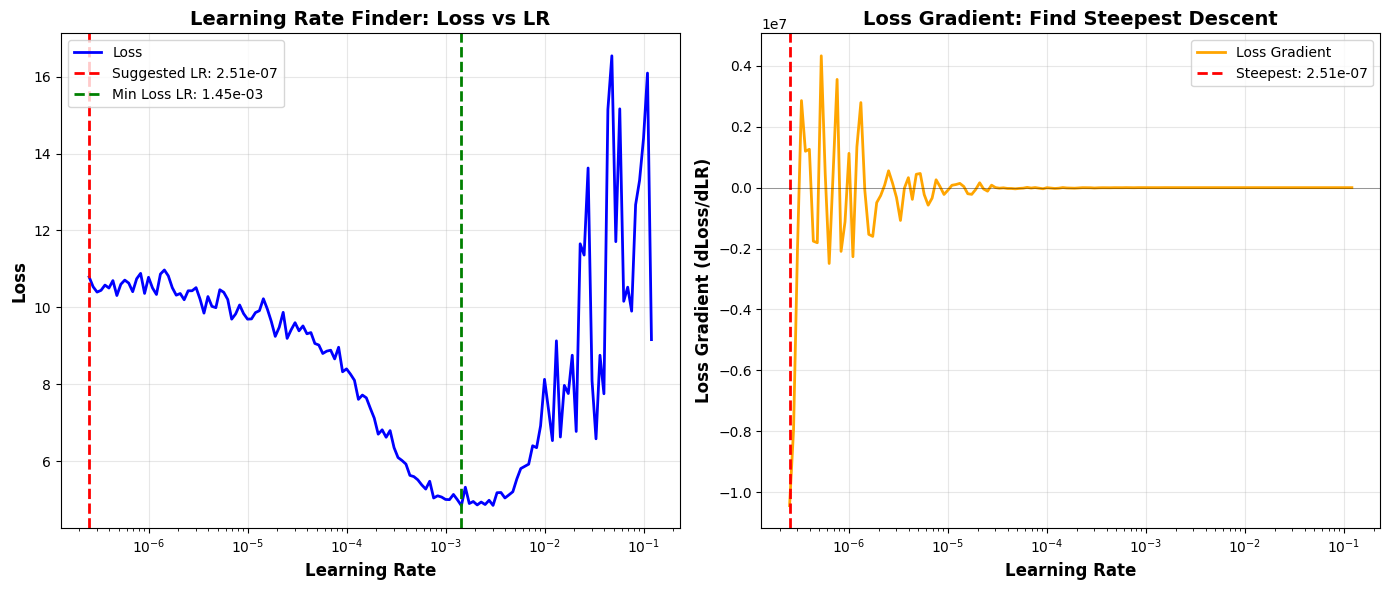


📊 LEARNING RATE FINDER RESULTS

✅ RECOMMENDED LEARNING RATE (Steepest Descent):
   → Primary recommendation: 2.51e-07
   → Conservative (1/10):    2.51e-08
   → Aggressive (1/3):       8.37e-08

📈 MINIMUM LOSS LEARNING RATE:
   → LR at minimum loss: 1.45e-03
   → Use as upper bound

💡 RECOMMENDATIONS:
   1. Start with: 2.51e-07
   2. If unstable, try: 2.51e-08
   3. Max LR should be < 1.45e-03




In [36]:
# Create LR Finder
lr_finder = LRFinder(
    model=model,
    optimizer=optimizer,
    criterion=F.nll_loss,
    device=device
)

# Run LR Finder
suggested_lr, min_loss_lr = lr_finder.find(
    train_loader,
    start_lr=1e-7,    # Start from very small
    end_lr=10,        # Go up to 10
    num_iter=200      # Try 200 different learning rates
)


🔎 Zooming into a specific range...

🔍 Starting Learning Rate Finder...
   Range: 2.51e-07 → 1.45e-03
   Iterations: 100



LR Finder: 100%|████████████████████████| 100/100 [15:48<00:00,  9.49s/it, LR=1.33e-03, Loss=5.1257]


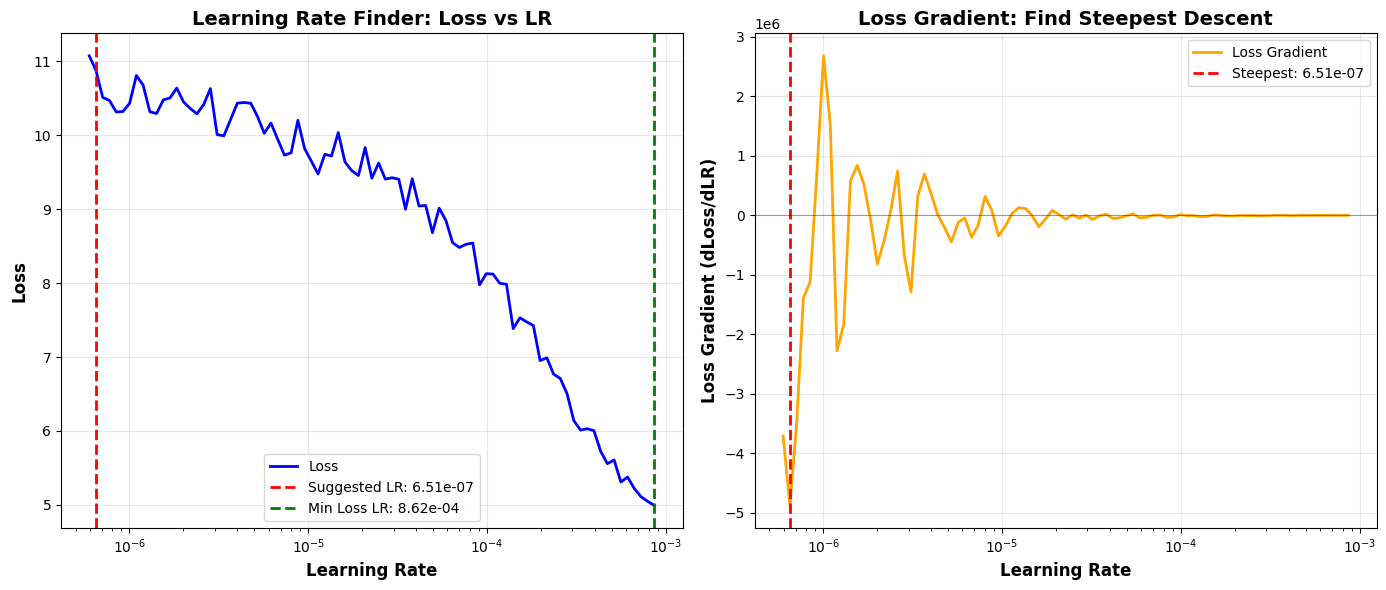


📊 LEARNING RATE FINDER RESULTS

✅ RECOMMENDED LEARNING RATE (Steepest Descent):
   → Primary recommendation: 6.51e-07
   → Conservative (1/10):    6.51e-08
   → Aggressive (1/3):       2.17e-07

📈 MINIMUM LOSS LEARNING RATE:
   → LR at minimum loss: 8.62e-04
   → Use as upper bound

💡 RECOMMENDATIONS:
   1. Start with: 6.51e-07
   2. If unstable, try: 6.51e-08
   3. Max LR should be < 8.62e-04




In [38]:
# If you want to zoom into a specific range
print("\n🔎 Zooming into a specific range...\n")

suggested_lr_zoom, min_loss_lr_zoom = lr_finder.find(
    train_loader,
    start_lr=2.51e-07,    # Narrower range
    end_lr=1.45e-03,         # Narrower range
    num_iter=100
)

In [39]:
# Save the recommended LR for later use
recommended_config = {
    'suggested_lr': suggested_lr,
    'conservative_lr': suggested_lr / 10,
    'aggressive_lr': suggested_lr / 3,
    'max_lr': min_loss_lr,
    'device': str(device)
}

print("\n📝 Configuration for Training:")
print("="*50)
for key, value in recommended_config.items():
    if 'lr' in key:
        print(f"{key:20s}: {value:.2e}")
    else:
        print(f"{key:20s}: {value}")
print("="*50)

# You can now use this in your training script:
print(f"\n💻 Use in training:")
print(f"config.training.learning_rate = {suggested_lr:.2e}")


📝 Configuration for Training:
suggested_lr        : 2.51e-07
conservative_lr     : 2.51e-08
aggressive_lr       : 8.37e-08
max_lr              : 1.45e-03
device              : cuda

💻 Use in training:
config.training.learning_rate = 2.51e-07


ADAM

In [46]:
# Create optimizer (initial LR doesn't matter, will be overridden)
optimizer = optim.Adam(
    model.parameters(),
    lr=0.01,
    weight_decay=0.0001
)

print("Optimizer created")

Optimizer created


🔍 Starting Learning Rate Finder...
   Range: 1.00e-07 → 1.00e+01
   Iterations: 200



LR Finder:  92%|█████████████████████  | 183/200 [13:21<01:14,  4.38s/it, LR=2.09e+00, Loss=74.8738]
Exception ignored in: <function tqdm.__del__ at 0x0000026E7ED2D8A0>
Traceback (most recent call last):
  File "c:\Users\krish\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\std.py", line 1148, in __del__



Stopping early: loss diverged at iteration 183


    self.close()
  File "c:\Users\krish\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
LR Finder:   0%|                                                         | 0/200 [22:16:40<?, ?it/s]


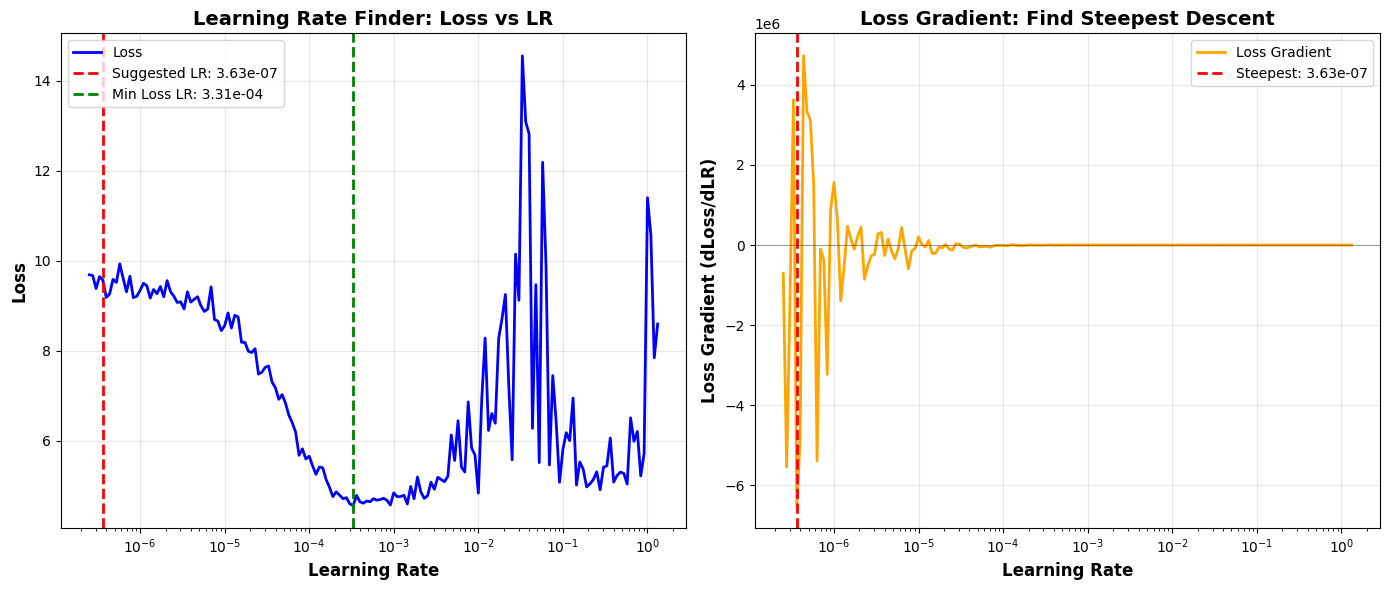


📊 LEARNING RATE FINDER RESULTS

✅ RECOMMENDED LEARNING RATE (Steepest Descent):
   → Primary recommendation: 3.63e-07
   → Conservative (1/10):    3.63e-08
   → Aggressive (1/3):       1.21e-07

📈 MINIMUM LOSS LEARNING RATE:
   → LR at minimum loss: 3.31e-04
   → Use as upper bound

💡 RECOMMENDATIONS:
   1. Start with: 3.63e-07
   2. If unstable, try: 3.63e-08
   3. Max LR should be < 3.31e-04




In [47]:
# Create LR Finder
lr_finder = LRFinder(
    model=model,
    optimizer=optimizer,
    criterion=F.nll_loss,
    device=device
)

# Run LR Finder
suggested_lr, min_loss_lr = lr_finder.find(
    train_loader,
    start_lr=1e-7,    # Start from very small
    end_lr=10,        # Go up to 10
    num_iter=200      # Try 200 different learning rates
)

In [ ]:
# If you want to zoom into a specific range
print("\n🔎 Zooming into a specific range...\n")

suggested_lr_zoom, min_loss_lr_zoom = lr_finder.find(
    train_loader,
    start_lr=2.51e-07,    # Narrower range
    end_lr=1.45e-03,         # Narrower range
    num_iter=100
)


🔎 Zooming into a specific range...

🔍 Starting Learning Rate Finder...
   Range: 2.51e-07 → 1.45e-03
   Iterations: 100



LR Finder: 100%|████████████████████████| 100/100 [15:48<00:00,  9.49s/it, LR=1.33e-03, Loss=5.1257]


Adagrad

In [ ]:
# Create optimizer (initial LR doesn't matter, will be overridden)
optimizer = optim.Adagrad(
    model.parameters(),
    lr=0.01,  # Initial LR (will be overridden by LR finder)
    momentum=0.9,
    weight_decay=0.0001
)

print("Optimizer created")

🔍 Starting Learning Rate Finder...
   Range: 1.00e-07 → 1.00e+01
   Iterations: 200



LR Finder:  78%|██████████████████     | 157/200 [23:11<06:21,  8.86s/it, LR=1.91e-01, Loss=28.8710]



Stopping early: loss diverged at iteration 157


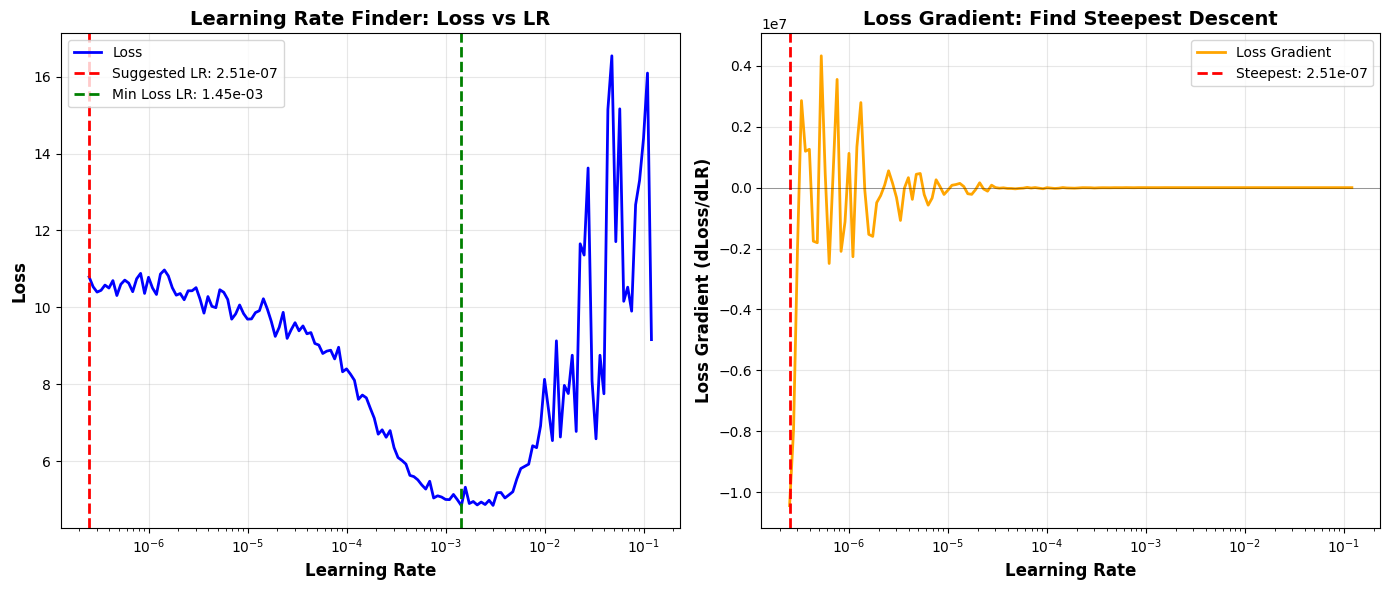


📊 LEARNING RATE FINDER RESULTS

✅ RECOMMENDED LEARNING RATE (Steepest Descent):
   → Primary recommendation: 2.51e-07
   → Conservative (1/10):    2.51e-08
   → Aggressive (1/3):       8.37e-08

📈 MINIMUM LOSS LEARNING RATE:
   → LR at minimum loss: 1.45e-03
   → Use as upper bound

💡 RECOMMENDATIONS:
   1. Start with: 2.51e-07
   2. If unstable, try: 2.51e-08
   3. Max LR should be < 1.45e-03




In [ ]:
# Create LR Finder
lr_finder = LRFinder(
    model=model,
    optimizer=optimizer,
    criterion=F.nll_loss,
    device=device
)

# Run LR Finder
suggested_lr, min_loss_lr = lr_finder.find(
    train_loader,
    start_lr=1e-7,    # Start from very small
    end_lr=10,        # Go up to 10
    num_iter=200      # Try 200 different learning rates
)

In [ ]:
# If you want to zoom into a specific range
print("\n🔎 Zooming into a specific range...\n")

suggested_lr_zoom, min_loss_lr_zoom = lr_finder.find(
    train_loader,
    start_lr=2.51e-07,    # Narrower range
    end_lr=1.45e-03,         # Narrower range
    num_iter=100
)


🔎 Zooming into a specific range...

🔍 Starting Learning Rate Finder...
   Range: 2.51e-07 → 1.45e-03
   Iterations: 100



LR Finder: 100%|████████████████████████| 100/100 [15:48<00:00,  9.49s/it, LR=1.33e-03, Loss=5.1257]


RMSProp

In [ ]:
# Create optimizer (initial LR doesn't matter, will be overridden)
optimizer = optim.RMSprop(
    model.parameters(),
    lr=0.01,  # Initial LR (will be overridden by LR finder)
    momentum=0.9,
    weight_decay=0.0001
)

print("Optimizer created")

🔍 Starting Learning Rate Finder...
   Range: 1.00e-07 → 1.00e+01
   Iterations: 200



LR Finder:  78%|██████████████████     | 157/200 [23:11<06:21,  8.86s/it, LR=1.91e-01, Loss=28.8710]



Stopping early: loss diverged at iteration 157


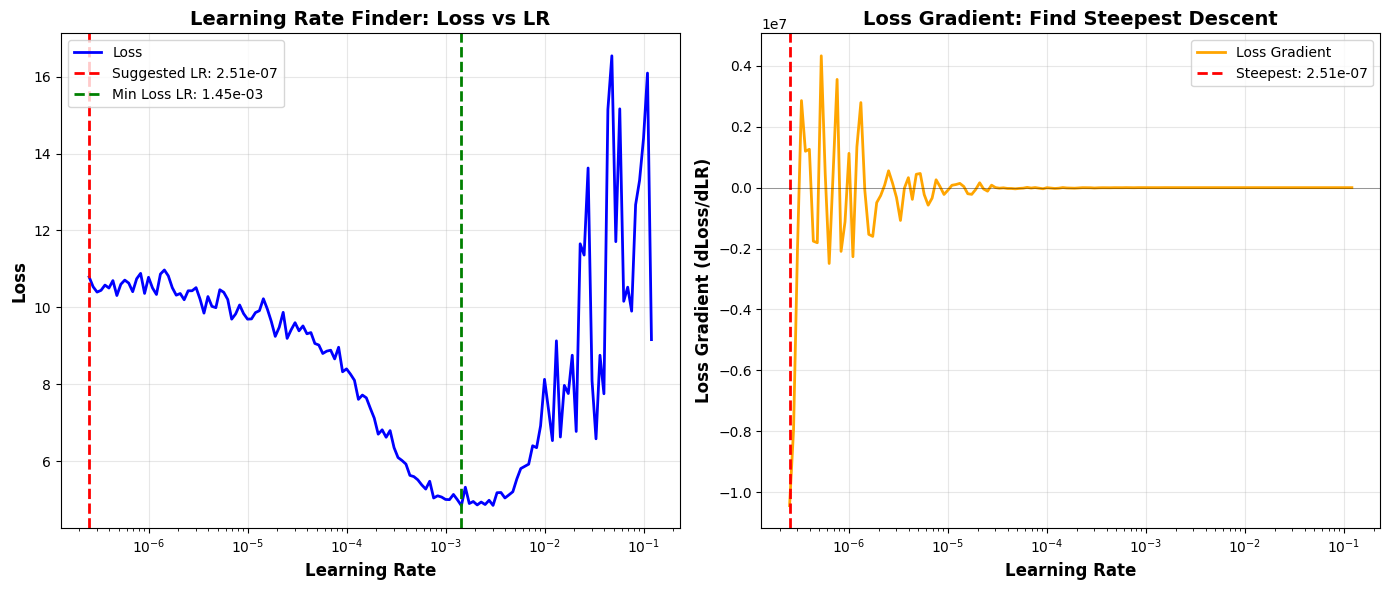


📊 LEARNING RATE FINDER RESULTS

✅ RECOMMENDED LEARNING RATE (Steepest Descent):
   → Primary recommendation: 2.51e-07
   → Conservative (1/10):    2.51e-08
   → Aggressive (1/3):       8.37e-08

📈 MINIMUM LOSS LEARNING RATE:
   → LR at minimum loss: 1.45e-03
   → Use as upper bound

💡 RECOMMENDATIONS:
   1. Start with: 2.51e-07
   2. If unstable, try: 2.51e-08
   3. Max LR should be < 1.45e-03




In [ ]:
# Create LR Finder
lr_finder = LRFinder(
    model=model,
    optimizer=optimizer,
    criterion=F.nll_loss,
    device=device
)

# Run LR Finder
suggested_lr, min_loss_lr = lr_finder.find(
    train_loader,
    start_lr=1e-7,    # Start from very small
    end_lr=10,        # Go up to 10
    num_iter=200      # Try 200 different learning rates
)

In [ ]:
# If you want to zoom into a specific range
print("\n🔎 Zooming into a specific range...\n")

suggested_lr_zoom, min_loss_lr_zoom = lr_finder.find(
    train_loader,
    start_lr=2.51e-07,    # Narrower range
    end_lr=1.45e-03,         # Narrower range
    num_iter=100
)


🔎 Zooming into a specific range...

🔍 Starting Learning Rate Finder...
   Range: 2.51e-07 → 1.45e-03
   Iterations: 100



LR Finder: 100%|████████████████████████| 100/100 [15:48<00:00,  9.49s/it, LR=1.33e-03, Loss=5.1257]


In [48]:
"""
Compute Confusion Matrix for CIFAR-100 Model
Generates confusion matrix and various visualizations

Author: Krishnakanth
Date: 2025-10-10
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
from tqdm import tqdm

# Import your model
from model import CIFAR100Model, ModelConfig

# CIFAR-100 class names
CIFAR100_CLASSES = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea',
    'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]


KeyboardInterrupt: 